#  code from: 
https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/03/08/image-mean-std.html

In [1]:
#mean and std based on dataset
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import pickle
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline


device=torch.device('cpu')
num_workers=4 
image_size=256
batch_size=64

In [2]:
df=pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Sophie_Chen/file_info.csv")
print(df.head())

   Unnamed: 0      IDs  patient  \
0           0  109_A1c      109   
1           1   10_A1a       10   
2           2   10_A1b       10   
3           3   10_A2b       10   
4           4  110_A2b      110   

                                      patch_info_loc  \
0  /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Stud...   
1  /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Stud...   
2  /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Stud...   
3  /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Stud...   
4  /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Stud...   

                                             npy_loc    set  
0  /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Stud...  train  
1  /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Stud...  train  
2  /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Stud...  train  
3  /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Stud...  train  
4  /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Stud...  train  


In [3]:
image_df=pd.DataFrame(columns=['IDs','data_path'])
image_df['IDs']=df['IDs']
image_df['data_path']=df['npy_loc']

In [4]:
for i in tqdm.tqdm(range(95)):
    patch_data=[]
    data_paths=image_df['data_path'][i]
    data=np.load(data_paths)
    for item in data:
        patch_data.append(item)
    #print(patch_data)

100%|███████████████████████████████████████████| 95/95 [01:55<00:00,  1.21s/it]


In [5]:
patch_df=pd.DataFrame({'col':patch_data})
patch_df.head()

,col
0,"[[[243, 241, 242], [243, 241, 242], [243, 241,..."
1,"[[[244, 242, 243], [244, 242, 243], [244, 242,..."
2,"[[[243, 241, 242], [243, 241, 242], [243, 241,..."
3,"[[[243, 241, 242], [243, 241, 242], [243, 241,..."
4,"[[[160, 98, 135], [191, 131, 167], [226, 172, ..."


In [6]:
len(patch_df)

14432

In [7]:
patch_df.iloc[0]['col']

array([[[243, 241, 242],
        [243, 241, 242],
        [243, 241, 242],
        ...,
        [242, 240, 241],
        [244, 242, 243],
        [246, 244, 245]],

       [[243, 241, 242],
        [243, 241, 242],
        [243, 241, 242],
        ...,
        [242, 240, 241],
        [242, 240, 241],
        [241, 239, 240]],

       [[243, 241, 242],
        [243, 241, 242],
        [243, 241, 242],
        ...,
        [242, 240, 241],
        [239, 237, 238],
        [237, 235, 236]],

       ...,

       [[243, 241, 242],
        [243, 241, 242],
        [243, 241, 242],
        ...,
        [137,  72, 130],
        [147,  79, 140],
        [148,  79, 142]],

       [[243, 241, 242],
        [243, 241, 242],
        [243, 241, 242],
        ...,
        [133,  68, 124],
        [142,  74, 135],
        [148,  80, 141]],

       [[243, 241, 242],
        [243, 241, 242],
        [243, 241, 242],
        ...,
        [151,  86, 142],
        [146,  78, 137],
        [135,  67, 128]]

In [8]:
class SCCData(Dataset):
    
    def __init__(self, data, transform=None):
        self.data=data
        self.transform=transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        image= self.data.iloc[idx]['col']
        
        if self.transform is not None:
            image=self.transform(image=image)['image']
        
        return image

In [9]:
augs = A.Compose([A.Resize(height = image_size, 
                           width  = image_size),
                  A.Normalize(mean = (0, 0, 0),
                              std  = (1, 1, 1)),
                  ToTensorV2()])

In [10]:
image_dataset=SCCData(data = patch_df, transform=augs)
image_loader=DataLoader(image_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

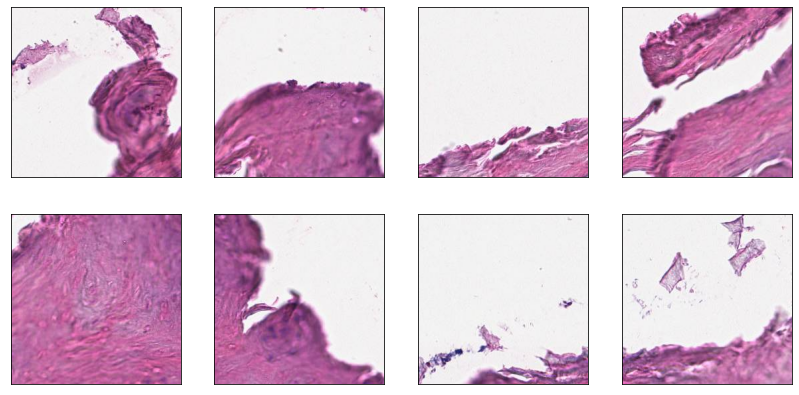

In [11]:
for batch_idx, inputs in enumerate(image_loader):
    fig=plt.figure(figsize=(14,7))
    for i in range (8):
        ax=fig.add_subplot(2,4,i+1, xticks=[], yticks=[])
        plt.imshow(inputs[i].numpy().transpose(1,2,0))
    break

In [12]:
#placeholders

psum=torch.tensor([0.0,0.0,0.0])
psum_sq=torch.tensor([0.0,0.0,0.0])

#loop through images
for inputs in tqdm.tqdm(image_loader):
    psum += inputs.sum(axis  = [0,2,3])
    psum_sq += (inputs **2).sum(axis= [0,2,3])

100%|█████████████████████████████████████████| 226/226 [00:07<00:00, 29.77it/s]


In [13]:
count=len(df)*image_size*image_size*image_size

total_mean = psum/count
total_var = (psum_sq / count) - (total_mean ** 2)
total_std = torch.sqrt(total_var)


#output
print('mean' + str(total_mean))
print('std' + str(total_std))

meantensor([0.4330, 0.3050, 0.4147])
stdtensor([0.3847, 0.3016, 0.3642])
